<a href="https://www.kaggle.com/code/mariuszcha/is-it-porsche-or-not?scriptVersionId=131640274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Is it Porsche?

Wanting to consolidate my knowledge about basics of FastAI, I created simple architecture in order to determine whether the picture from DuckDuckGo browser shows Porsche or Different car(Ferrari or Bentley).


## Step 1: Download images of cars...

In [85]:
!pip install -Uqq fastai duckduckgo_search
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastcore.all import *
from fastai.vision.all import *
from time import sleep
import time

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [86]:
# Using function above we search on DuckDuckGo 50 images of Porsche 911
urls = search_images('Porsche 930', max_images=50)
urls[8] # Example

'http://silodrome.com/wp-content/uploads/2016/07/Porsche-930-11.jpg'

**We are going to download one of pictures and examine how it looks like...**

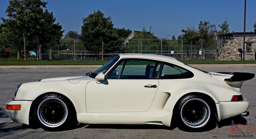

In [87]:
dest = 'porsche.jpg'
download_url(urls[5], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

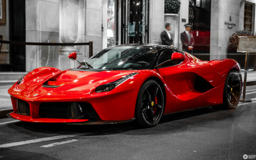

In [88]:
# As we can see - now it's two lines. We load 10 urls of first 10 Ferraris from DDG browser and load first one photo
# to ferari.jpg
download_url(search_images('ferrari', max_images=10)[3], 'ferrari.jpg', show_progress=False)
Image.open('ferrari.jpg').to_thumb(256,256)

In [89]:
# Basically we search phrases ferrari, porsche, bentley in DDG and download each
# picture into porsche_or_not catalog. We download 500 photos of each car.
# It is bascially more sophisticated version of code above where we were loading
# urls and saving them to specified directory

searches = 'ferrari','porsche','bentley'
path = Path('porsche_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True) #first flag = ignore information about existance of catalog
    download_images(dest, urls=search_images(f'{o}'))
    sleep(10)  # Pause between searches to avoid over-loading server
    resize_images(path/o, max_size=500, dest=path/o)

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


## Step 2: Train our model...

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [90]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

35

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

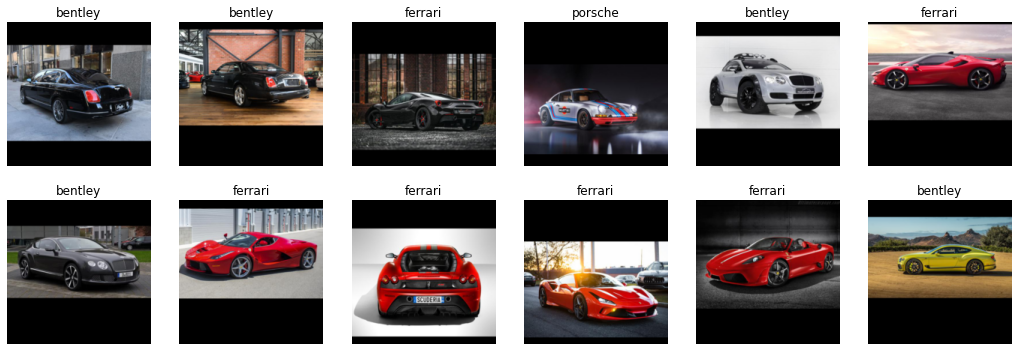

In [91]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=13),
    get_y=parent_label,
    item_tfms=[Resize(192, ResizeMethod.Pad, pad_mode='zeros')]
)
dls = cars.dataloaders(path, bs=64)

dls.show_batch(max_n=12, nrows=2, unique=False)

epoch,train_loss,valid_loss,error_rate,time
0,1.284200,0.502743,0.174807,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.458647,0.167964,0.061697,00:11
1,0.277198,0.091321,0.030848,00:11
2,0.172140,0.061965,0.020566,00:11


None

epoch,train_loss,valid_loss,error_rate,time
0,1.279090,0.464501,0.143959,00:11


epoch,train_loss,valid_loss,error_rate,time
0,0.470587,0.197370,0.071979,00:12
1,0.254945,0.027133,0.007712,00:11
2,0.149508,0.023689,0.007712,00:12


None

epoch,train_loss,valid_loss,error_rate,time
0,0.971941,0.542987,0.128535,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.272338,0.203426,0.069409,00:16
1,0.171233,0.074002,0.015424,00:15
2,0.104924,0.069804,0.010283,00:16


None

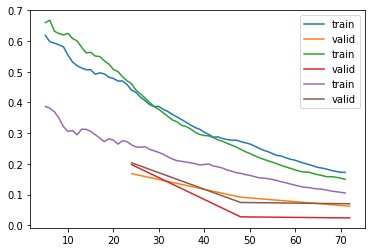

In [92]:
# Training model for 3 different resnets...
for i in [resnet18,resnet34,resnet101]:
    learn = vision_learner(dls, i, metrics=error_rate)
    learn.fine_tune(3)
    display(learn.recorder.plot_loss())

We can notice that brown model performs the best for validation set. It is resnet101. We are going to use it on our final model

epoch,train_loss,valid_loss,error_rate,time
0,1.026163,0.529178,0.136247,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.279920,0.124247,0.041131,00:16
1,0.179104,0.142523,0.041131,00:15
2,0.123340,0.030974,0.015424,00:16
3,0.073052,0.018587,0.002571,00:15
4,0.045278,0.013032,0.002571,00:16


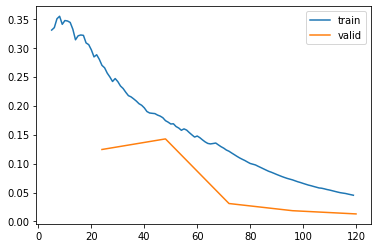

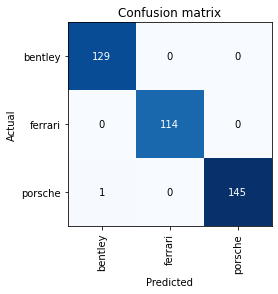

In [93]:
learn = vision_learner(dls, resnet101, metrics=error_rate)
learn.fine_tune(5) # 5 epochs
learn.recorder.plot_loss()

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

**As we can see, our model predicts mostly correctly. We can notice some mistakes:
4 Porsches were classified as Ferrari. According to plot_top_loss below - our model probably classify red cars as Ferrari because most photos of Ferraris are red. We could solve that providing more Red Porsches to our model.
Model also incorrectly classified some Bentleys and Ferraris as Porsche. That happens mostly in situation where it's Ferrari in shooting-brake configuration like GTC4 Lusso. The rear of the car can be interpreted as Porsche.**

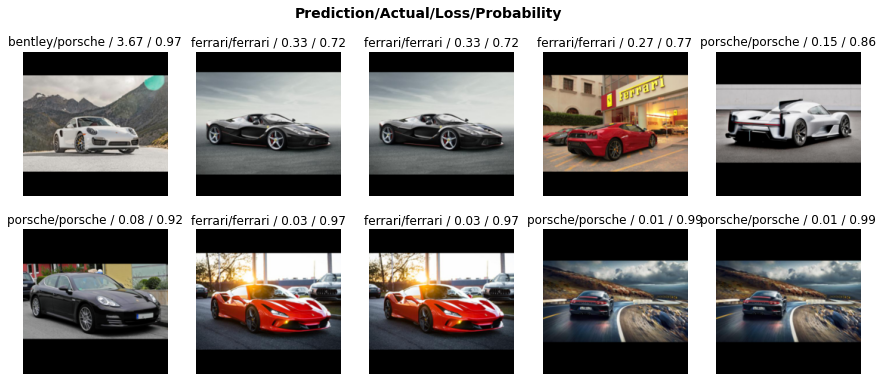

In [94]:
interp.plot_top_losses(10, nrows=2)

## Step 3: Use our model...

Let's test how our model perform on new Porsche, Ferrari and Bentley picture.

# With Porsche...

This is a: porsche.
Probability of Porsche: 0.9999997615814209


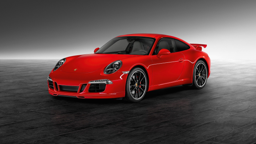

This is a: porsche.
Probability of Porsche: 0.9999978542327881


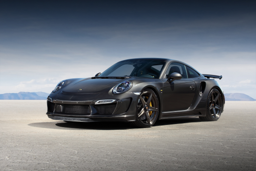

This is a: porsche.
Probability of Porsche: 0.9999991655349731


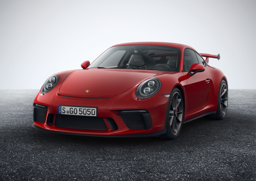

In [95]:
for i in range(3):
    download_url(search_images('porsche',max_images=4)[i], 'car.jpg', show_progress=True)
    isit_porsche,_,probs = learn.predict(PILImage.create('car.jpg'))
    print(f"This is a: {isit_porsche}.")
    print(f"Probability of Porsche: {probs[2]}")
    display(Image.open('car.jpg').to_thumb(256,256))

As we can see - our model performs quite good on Porsches! Even the red ones were classified correctly!

### With Ferrari...

This is a: ferrari.
Probability of Porsche: 0.00014391793229151517


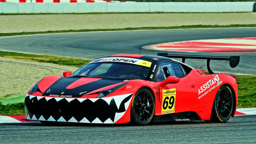

This is a: ferrari.
Probability of Porsche: 1.6184434706040945e-14


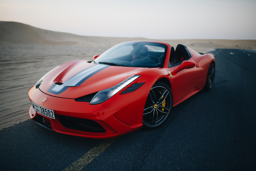

This is a: ferrari.
Probability of Porsche: 1.4670452401333023e-05


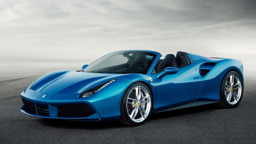

In [96]:
for i in range(3):
    download_url(search_images('ferrari vehicle',max_images=4)[i], 'car.jpg', show_progress=True)
    isit_porsche,_,probs = learn.predict(PILImage.create('car.jpg'))
    print(f"This is a: {isit_porsche}.")
    print(f"Probability of Porsche: {probs[2]}")
    #print(np.round(probs,3))
    display(Image.open('car.jpg').to_thumb(256,256))

Ferraris were also classified correctly!

### With Bentley...

This is a: bentley.
Probability of Porsche: 7.655769422854064e-07


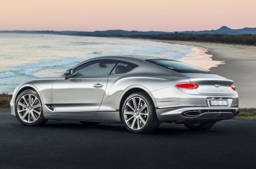

This is a: bentley.
Probability of Porsche: 1.207955847348785e-06


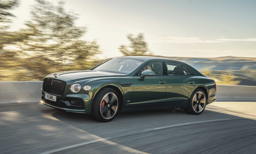

This is a: bentley.
Probability of Porsche: 2.7487300258144387e-07


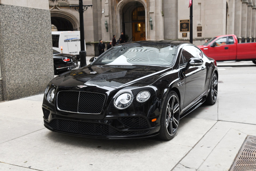

In [97]:
for i in range(3):
    download_url(search_images('bentley',max_images=4)[i], 'car.jpg', show_progress=True)
    isit_porsche,_,probs = learn.predict(PILImage.create('car.jpg'))
    print(f"This is a: {isit_porsche}.")
    print(f"Probability of Porsche: {probs[2]}")
    #print(np.round(probs,3))
    display(Image.open('car.jpg').to_thumb(256,256))

Bentleys were also classified correctly!

As we know - most photos of Ferraris in DDG are red. Let's see how our model perform on Red Porsches...
### With Red Porsche...

This is a: ferrari.
Probability of Porsche: 0.3972649574279785


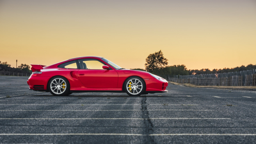

This is a: ferrari.
Probability of Porsche: 0.4950132668018341


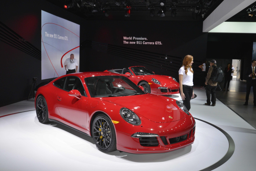

This is a: porsche.
Probability of Porsche: 0.9968194961547852


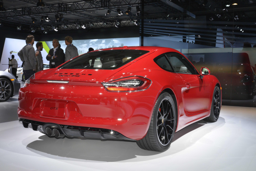

In [98]:
for i in range(3):
    download_url(search_images('red porsche 911',max_images=4)[i], 'car.jpg', show_progress=True)
    isit_porsche,_,probs = learn.predict(PILImage.create('car.jpg'))
    print(f"This is a: {isit_porsche}.")
    print(f"Probability of Porsche: {probs[2]}")
    #print(np.round(probs,3))
    display(Image.open('car.jpg').to_thumb(256,256))

As we can see - The model identified 2 Porsches as Ferrari probably because of the color - as I wrote earlier. We can solve that by providing more photos of red cars other that Ferraris to our model.

As we know - Porsche shapes are kinda derived from old VW Beetle shapes. Maybe not the new ones but let's see what our model will see when we will provide VW photo to it...

### With VW Beetle

This is a: porsche.
Probability of Porsche: 0.9996894598007202


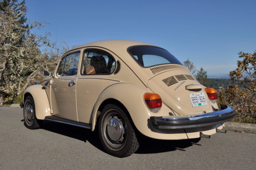

This is a: porsche.
Probability of Porsche: 0.7093313336372375


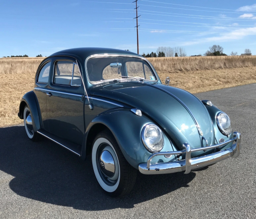

This is a: porsche.
Probability of Porsche: 0.9999876022338867


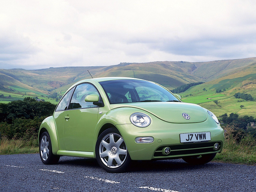

In [99]:
for i in range(3):
    download_url(search_images('beetle vw',max_images=5)[i], 'car.jpg', show_progress=True)
    isit_porsche,_,probs = learn.predict(PILImage.create('car.jpg'))
    print(f"This is a: {isit_porsche}.")
    print(f"Probability of Porsche: {probs[2]}")
    #print(np.round(probs,3))
    display(Image.open('car.jpg').to_thumb(256,256))

As we can see - it identifies VW as Porsche. Maybe because of chassis line(which is very consistent, not sharp) ane cause of the shape of headlights. Circle... The last one was identified as bentley.

### How to solve problems?
* Provide more red Porsches as our train data - to learn distinctions between...
* Test  Inception or EfficientNet instead of ResNet

In [100]:
# Used to clean output directory...
#import shutil
#shutil.rmtree("/kaggle/working")